# Préprocessing et normalisation

# 1.0 Chargement des modules et des données

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import json
import plotly.graph_objects as go
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.api
from scipy.stats import randint
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


In [2]:
from google.colab import files
# téléchargez le fichier depuis mon PC vers Google Colab:
upload = files.upload()

Saving nba1_data_raw.json to nba1_data_raw.json


# 1.1 Affichage des données brutes

In [4]:

# Pour un JSON simple (liste d'objets)
df = pd.read_json('nba1_data_raw.json')
df.to_csv('nba1_data_raw.csv', index=False)

# Chargement des données brutes
df_raw = pd.read_csv('nba1_data_raw.csv')

# Affichage des premières lignes et structure
print(df_raw.head())
print(df_raw.info())
print(df_raw.describe())

    Game ID  Game Event ID  Player ID Player Name     Team ID  \
0  29700427            389        100  Tim Legler  1610612764   
1  29700427            406        100  Tim Legler  1610612764   
2  29700427            475        100  Tim Legler  1610612764   
3  29700427            487        100  Tim Legler  1610612764   
4  29700427            497        100  Tim Legler  1610612764   

            Team Name  Period  Minutes Remaining  Seconds Remaining  \
0  Washington Wizards       4                 11                 22   
1  Washington Wizards       4                  9                 36   
2  Washington Wizards       4                  3                  7   
3  Washington Wizards       4                  1                 45   
4  Washington Wizards       4                  0                 45   

  Action Type  ... Shot Zone Area  Shot Zone Range Shot Distance X Location  \
0   Jump Shot  ...  Right Side(R)         8-16 ft.            15        117   
1   Jump Shot  ...  Righ

# 1.2 Suppression des variable non utilisées

In [5]:
# Colonnes à supprimer
cols_to_drop = ['Game ID', 'Game Event ID', 'Player Name', 'Team ID', 'Team Name',
                'Period', 'Season Type', 'Game Date', 'Home Team', 'Away Team']

# Création d'un nouveau dataframe sans ces colonnes
nba1_data_clean = df_raw.drop(columns=cols_to_drop)



# 1.3 Vérification et suppression des doublons

In [6]:
# Vérification des doublons
duplicates_count = nba1_data_clean.duplicated().sum()
print(f"Nombre de doublons: {duplicates_count}")

# Suppression des doublons si nécessaire
nba1_data_clean = nba1_data_clean.drop_duplicates()


Nombre de doublons: 347


# 1.4 Replacement des valeurs manquantes pour les colonnes numériques

In [7]:
# Vérification des valeurs manquantes
missing_values = nba1_data_clean.isnull().sum()
print("Valeurs manquantes par colonne:")
print(missing_values)

# Remplacement des valeurs manquantes pour les colonnes numériques
numeric_cols = nba1_data_clean.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    if nba1_data_clean[col].isnull().sum() > 0:
        # Remplacement par la médiane
        nba1_data_clean[col].fillna(nba1_data_clean[col].median(), inplace=True)


Valeurs manquantes par colonne:
Player ID            0
Minutes Remaining    0
Seconds Remaining    0
Action Type          0
Shot Type            0
Shot Zone Basic      0
Shot Zone Area       0
Shot Zone Range      0
Shot Distance        0
X Location           0
Y Location           0
Shot Made Flag       0
dtype: int64


# 1.5 Feature_engineering ---transformation du temps

In [8]:
# Conversion des minutes et secondes en secondes totales restantes
try:
    # Essayer avec les noms originaux
    nba1_data_clean['Total_Seconds_Remaining'] = (nba1_data_clean['Minutes Remaining'] * 60) + nba1_data_clean['Seconds Remaining']
    nba1_data_clean = nba1_data_clean.drop(columns=['Minutes Remaining', 'Seconds Remaining'])
except KeyError:
    # Si erreur, trouver les colonnes temporelles
    time_cols = [col for col in nba1_data_clean.columns if 'minute' in col.lower() or 'second' in col.lower() or 'remaining' in col.lower()]
    print(f"Colonnes temporelles disponibles: {time_cols}")

    # Trouver les noms exacts
    minutes_col = [col for col in time_cols if 'minute' in col.lower()][0]
    seconds_col = [col for col in time_cols if 'second' in col.lower()][0]

    # Créer la nouvelle caractéristique
    nba1_data_clean['Total_Seconds_Remaining'] = (nba1_data_clean[minutes_col] * 60) + nba1_data_clean[seconds_col]
    nba1_data_clean = nba1_data_clean.drop(columns=[minutes_col, seconds_col])

# 1.6 Feature_engineering ---transformation du type de tir

In [9]:
# Encodage du type de tir
def encode_shot_type(shot_type):
    if shot_type == '2PT Field Goal':
        return 2
    elif shot_type == '3PT Field Goal':
        return 3
    else:
        return 0  # Cas improbable

nba1_data_clean['Shot_Type_Encoded'] = nba1_data_clean['Shot Type'].apply(encode_shot_type)


# 1.7 Feature_engineering --transformation de la distance du tir

In [10]:
# Conversion de pieds en mètres (1 pied = 0.3048 mètre)
nba1_data_clean['Shot_Distance_Meters'] = nba1_data_clean['Shot Distance'] * 0.3048


# 1.8 Feature_engineering -- transformation de Zone de tir

In [11]:
# Création de la colonne Shot_Zone_Range_Numeric AVANT de l'utiliser
zone_range_mapping = {
    'Less Than 8 ft.': 1,
    '8-16 ft.': 2,
    '16-24 ft.': 3,
    '24+ ft.': 4,
    'Back Court Shot': 5
}
nba1_data_clean['Shot_Zone_Range_Numeric'] = nba1_data_clean['Shot Zone Range'].map(zone_range_mapping).fillna(0)

In [12]:
# Création de la variable de zone combinée (7 zones)
def create_combined_zone(basic, area, range_num):
    if basic == 'Restricted Area':
        return 1  # Zone restreinte près du panier
    elif basic == 'In The Paint (Non-RA)':
        return 2  # Dans la raquette (hors zone restreinte)
    elif basic == 'Mid-Range':
        if area in ['Left Side(L)', 'Left Side Center(LC)']:
            return 3  # Mid-range côté gauche
        else:
            return 4  # Mid-range côté droit ou centre
    elif basic == 'Above the Break 3':
        return 5  # 3 points au-dessus de la ligne
    elif 'Corner 3' in basic:
        return 6  # Corner 3 (gauche ou droite)
    elif basic == 'Backcourt':
        return 7  # Tir depuis son propre terrain
    else:
        return 0  # Autre

# Maintenant on peut combiner cette colonne
nba1_data_clean['Shot_Zone_Combined'] = nba1_data_clean.apply(
    lambda row: create_combined_zone(row['Shot Zone Basic'], row['Shot Zone Area'], row['Shot_Zone_Range_Numeric']),
    axis=1
)

# 1.9 Sélection des variables finales

In [13]:
# Sélection des variables finales
dataset_final = nba1_data_clean[[
    'Player ID',                  # Identifiant du joueur
    'X Location',                 # Position X sur le terrain
    'Y Location',                 # Position Y sur le terrain
    'Total_Seconds_Remaining',    # Temps total restant
    'Shot_Type_Encoded',          # Type de tir (2 pts ou 3 pts)
    'Shot_Distance_Meters',       # Distance convertie en mètres
    'Shot_Zone_Combined',         # Zone de tir (7 zones)
    'Shot Made Flag'              # Variable cible (si le tir est réussi)
]]

# 2.0  Enregistrement du dataset final

In [14]:
# Enregistrement du dataset final
dataset_final.to_csv('nba1_shots_preprocessed_optimise.csv', index=False)
print("Preprocessing optimisé terminé avec 7 variables !")

Preprocessing optimisé terminé avec 7 variables !


In [15]:
# Chargement du dataset final
df = pd.read_csv('nba1_shots_preprocessed_optimise.csv')

# Affichage des premières lignes et structure
print(df.head())
print(df.info())
print(df.describe())


   Player ID  X Location  Y Location  Total_Seconds_Remaining  \
0        100         117         109                      682   
1        100         143          25                      576   
2        100         -87          55                      187   
3        100          -1          53                      105   
4        100          89         113                       45   

   Shot_Type_Encoded  Shot_Distance_Meters  Shot_Zone_Combined  Shot Made Flag  
0                  2                4.5720                   4               1  
1                  2                4.2672                   4               0  
2                  2                3.0480                   3               0  
3                  2                1.5240                   2               0  
4                  2                4.2672                   4               0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49653 entries, 0 to 49652
Data columns (total 8 columns):
 #   Column    

# Matrice de corrélation


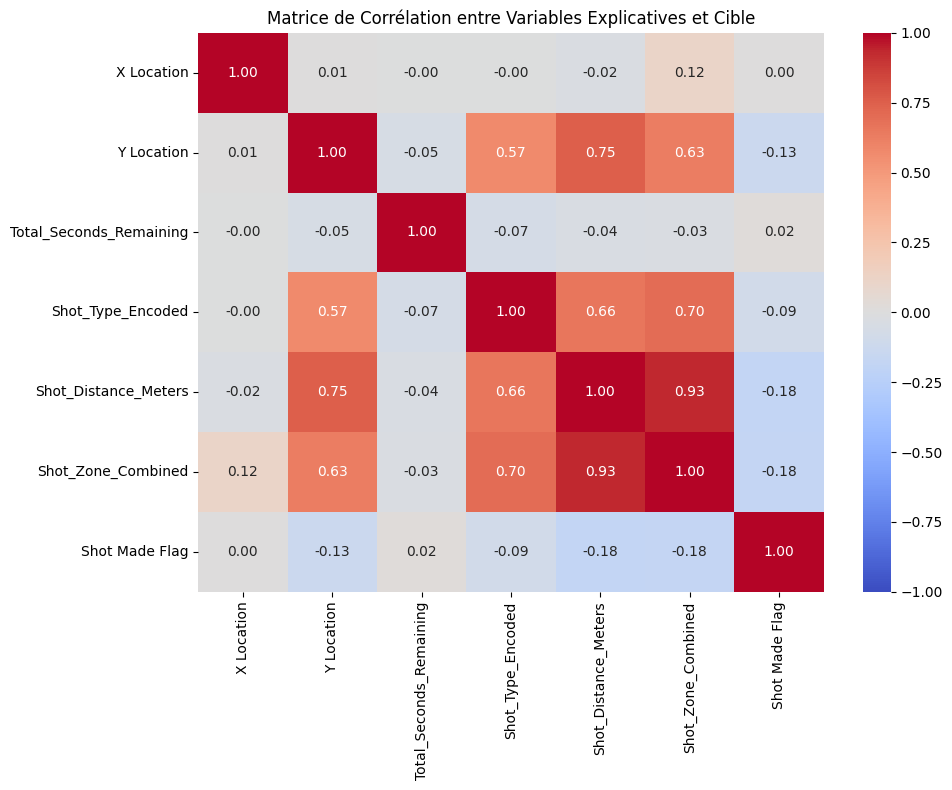

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
df = pd.read_csv('nba1_shots_preprocessed_optimise.csv')

# Calcul de la matrice de corrélation pour les variables numériques
correlation_matrix = df[['X Location', 'Y Location', 'Total_Seconds_Remaining',
                      'Shot_Type_Encoded', 'Shot_Distance_Meters',
                      'Shot_Zone_Combined', 'Shot Made Flag']].corr()

# Visualisation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Matrice de Corrélation entre Variables Explicatives et Cible')
plt.tight_layout()
plt.show()


# La matrice de corrélation montre:

Une corrélation négative (-0.18) entre 'Shot_Distance_Meters' et 'Shot Made Flag', confirmant que plus la distance augmente, plus la probabilité de réussite diminue

Une corrélation négative (-0.09) entre 'Shot_Type_Encoded' et 'Shot Made Flag', indiquant que les tirs à 3 points (encodés comme 3) ont un taux de réussite plus faible que les tirs à 2 points

Une faible corrélation entre 'Total_Seconds_Remaining' et la réussite du tir, suggérant que le temps restant n'est pas un facteur déterminant

# Analyse Spatiale des Tirs sur le Terrain

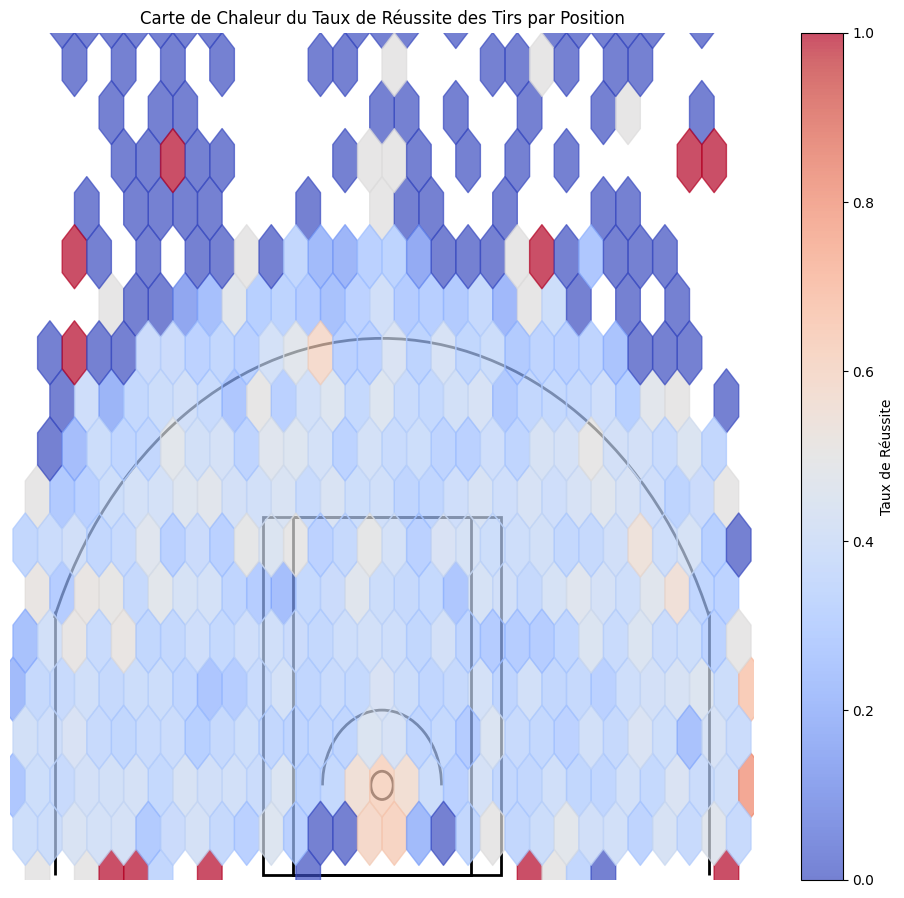

In [17]:
from matplotlib.patches import Circle, Rectangle, Arc

# Fonction pour dessiner un terrain de basketball
def draw_court(ax=None, color='black', lw=2):
    if ax is None:
        ax = plt.gca()

    # Dessiner le cercle du panier
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Dessiner la zone restreinte
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw, color=color)

    # Dessiner la raquette
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color, fill=False)
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color, fill=False)

    # Dessiner la ligne à 3 points
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw, color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw, color=color)

    elements = [hoop, restricted, outer_box, inner_box, corner_three_a, corner_three_b, three_arc]
    for element in elements:
        ax.add_patch(element)

    ax.set_xlim(-250, 250)
    ax.set_ylim(-50, 400)

    return ax

# Carte de chaleur du taux de réussite
plt.figure(figsize=(12, 11))
ax = plt.gca()
draw_court(ax)

# Utiliser hexbin pour créer une heatmap
h = plt.hexbin(df['X Location'], df['Y Location'], C=df['Shot Made Flag'],
               gridsize=30, cmap='coolwarm', alpha=0.7)
plt.colorbar(h, label='Taux de Réussite')
plt.title('Carte de Chaleur du Taux de Réussite des Tirs par Position')
plt.axis('off')
plt.show()


# La visualisation spatiale révèle:

Les zones près du panier (X et Y proches de 0) ont les taux de réussite les plus élevés

Les tirs dans les coins (positions X extrêmes avec Y modéré) ont des taux de réussite plus élevés pour les tirs à 3 points

Une distribution symétrique des taux de réussite par rapport à l'axe X=0

# Analyse par Zone de Tir

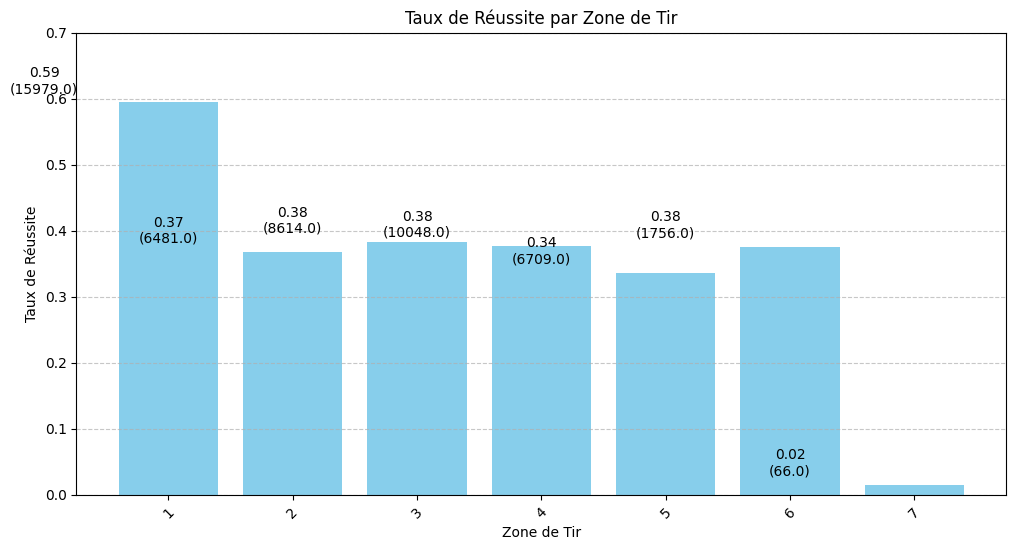

In [18]:
# Analyse du taux de réussite par zone
zone_stats = df.groupby('Shot_Zone_Combined')['Shot Made Flag'].agg(['count', 'mean'])
zone_stats.columns = ['Nombre de tirs', 'Taux de réussite']
zone_stats = zone_stats.reset_index()

plt.figure(figsize=(12, 6))
bars = plt.bar(zone_stats['Shot_Zone_Combined'], zone_stats['Taux de réussite'], color='skyblue')

# Ajouter les annotations
for i, bar in enumerate(bars):
    height = bar.get_height()
    count = zone_stats.iloc[i]['Nombre de tirs']
    plt.text(i, height + 0.01, f"{height:.2f}\n({count})", ha='center', va='bottom')

plt.title('Taux de Réussite par Zone de Tir')
plt.xlabel('Zone de Tir')
plt.ylabel('Taux de Réussite')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 0.7)
plt.show()


# L'analyse par zone montre:

Zone 1 (Restricted Area): taux de réussite le plus élevé (~59%)

Zone 2 (In The Paint): taux de réussite (~36%)

Zones 3 et 4 (Mid-Range): taux de réussite (37~38%)

Zone 6 (Corner 3): meilleur taux de réussite parmi les tirs à 3 points (~38%)

Zone 5 (Above the Break 3): taux de réussite (~33%)

# Relation entre Type de Tir et Réussite

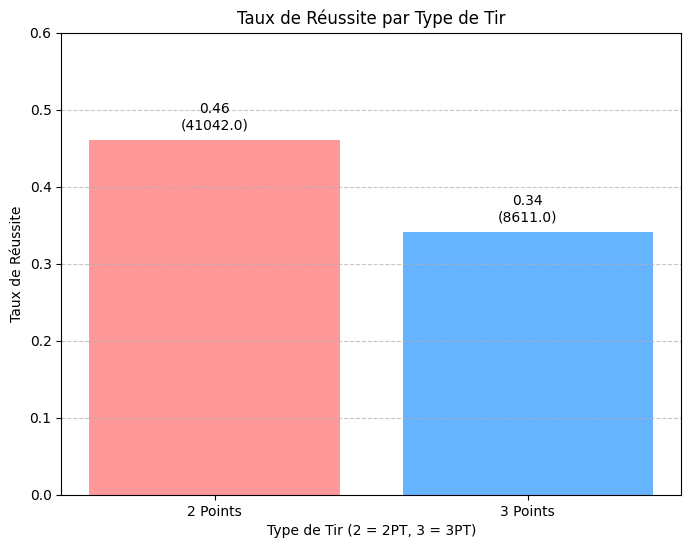

In [19]:
plt.figure(figsize=(8, 6))
shot_type_stats = df.groupby('Shot_Type_Encoded')['Shot Made Flag'].agg(['count', 'mean'])
shot_type_stats.columns = ['Nombre de tirs', 'Taux de réussite']
shot_type_stats = shot_type_stats.reset_index()

plt.bar(shot_type_stats['Shot_Type_Encoded'], shot_type_stats['Taux de réussite'], color=['#ff9999', '#66b3ff'])

for i, row in shot_type_stats.iterrows():
    plt.text(row['Shot_Type_Encoded'], row['Taux de réussite'] + 0.01,
             f"{row['Taux de réussite']:.2f}\n({row['Nombre de tirs']})",
             ha='center', va='bottom')

plt.title('Taux de Réussite par Type de Tir')
plt.xlabel('Type de Tir (2 = 2PT, 3 = 3PT)')
plt.ylabel('Taux de Réussite')
plt.xticks([2, 3], ['2 Points', '3 Points'])
plt.ylim(0, 0.6)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# L'analyse par type de tir confirme:

Les tirs à 2 points (encodés comme 2) ont un taux de réussite significativement plus élevé (~46%)

Les tirs à 3 points (encodés comme 3) ont un taux de réussite plus faible (~34%)

# Influence du Temps Restant

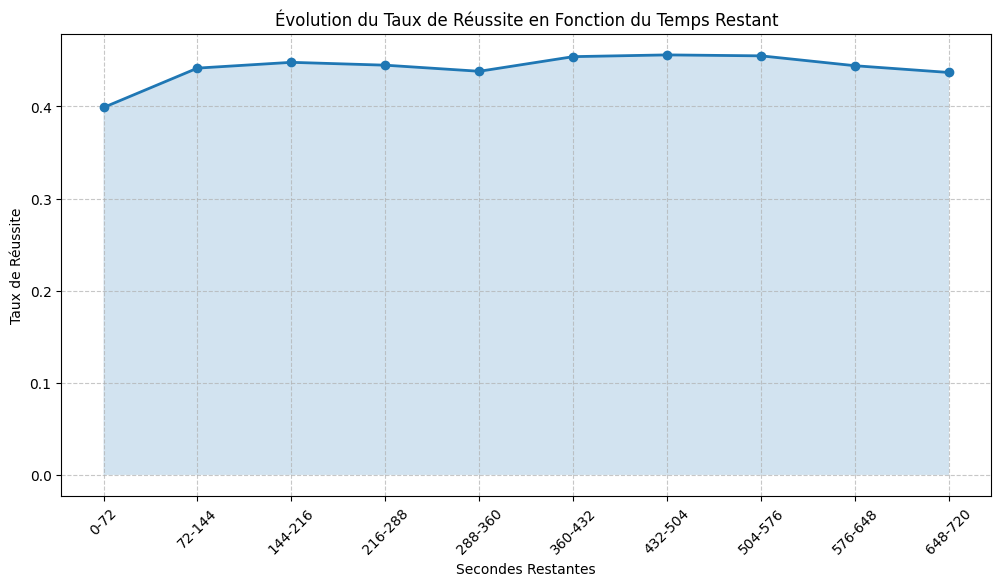

In [20]:
# Regrouper par tranches de temps
df['Time_Bins'] = pd.cut(df['Total_Seconds_Remaining'], bins=10, labels=False)
time_stats = df.groupby('Time_Bins')['Shot Made Flag'].agg(['count', 'mean'])
time_stats.columns = ['Nombre de tirs', 'Taux de réussite']
time_stats = time_stats.reset_index()

# Convertir les indices de tranches en secondes réelles
bin_labels = [f"{i*72}-{(i+1)*72}" for i in range(10)]

plt.figure(figsize=(12, 6))
plt.plot(time_stats['Time_Bins'], time_stats['Taux de réussite'], marker='o', linewidth=2)
plt.fill_between(time_stats['Time_Bins'], time_stats['Taux de réussite'], alpha=0.2)

plt.title('Évolution du Taux de Réussite en Fonction du Temps Restant')
plt.xlabel('Secondes Restantes')
plt.ylabel('Taux de Réussite')
plt.xticks(time_stats['Time_Bins'], bin_labels, rotation=45)
plt.grid(linestyle='--', alpha=0.7)
plt.show()


# L'analyse temporelle montre:

Une légère diminution du taux de réussite dans les dernières secondes du quart-temps

Une stabilité relative du taux de réussite sur la majeure partie du temps de jeu

Une légère augmentation du taux de réussite au milieu du quart-temps

# Relation entre Distance et Position du Tir

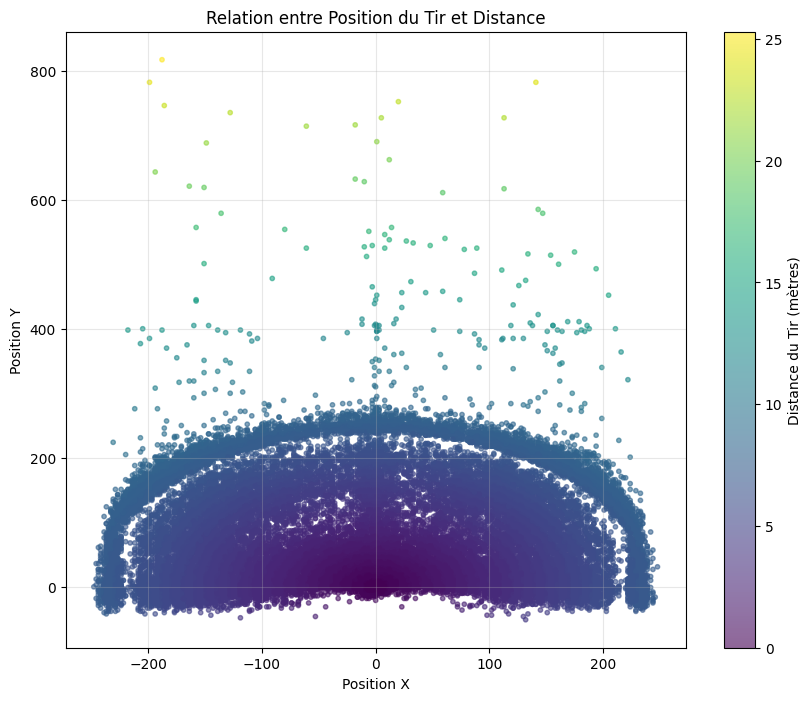

In [21]:
# Analyser la relation entre distance et coordonnées X,Y
plt.figure(figsize=(10, 8))
plt.scatter(df['X Location'], df['Y Location'], c=df['Shot_Distance_Meters'],
            cmap='viridis', alpha=0.6, s=10)
plt.colorbar(label='Distance du Tir (mètres)')
plt.title('Relation entre Position du Tir et Distance')
plt.xlabel('Position X')
plt.ylabel('Position Y')
plt.grid(alpha=0.3)
plt.show()


# Cette visualisation révèle:

Les tirs les plus éloignés sont généralement pris derrière la ligne à 3 points

Les positions X et Y ont une relation directe avec la distance du tir

La distribution des tirs suit les contours naturels du terrain de basketball

# Conclusion
L'analyse des variables optimisées pour la prédiction des tirs NBA montre que:

-Distance du tir: C'est le facteur le plus déterminant, avec une forte corrélation négative avec la réussite du tir.

-Position du tir: Les coordonnées X et Y sont importantes, avec les tirs près du panier et les tirs dans les coins ayant des taux de réussite plus élevés.

-Zone de tir: La zone 1 (Restricted Area) a le meilleur taux de réussite, suivie par la zone 2 (In The Paint) et la zone 6 (Corner 3).

-Type de tir: Les tirs à 2 points ont un taux de réussite significativement plus élevé que les tirs à 3 points.

-Temps restant: A une influence limitée sur la réussite du tir, avec une légère baisse de performance dans les dernières secondes.

Ces visualisations confirment l'importance de la position spatiale (distance et zone) comme variables prédictives principales pour déterminer si un tir NBA sera réussi.